# Current clamp
Current clamp recordings are one of the two most common experiment types you will see in papers using path-clamp. Current clamp experiments allow you to get active parameters of cells. Namely gain, rheobase and spike threshold. Current clamp recordings typically use stepped currrent injections or ramps and you are investigating the voltage change due to the current injection and whether the cell spikes.

## Experimental considerations for current clamp recordings
### Internal and external solutions
You will need to a standard ACSF for recording. Usually the ACSF bath is mantained at physiological temperature which is considered ~32C however you can record at room temperature. I recommend recording at 32C. You can include drugs in the bath to block synaptic activity but do not need to include these. If you are having a lot of recurrent input that is driving spikes, depolarizations or hyperpolarizations in your cells if may be good to include some drugs to block synpatic currents. The one problem with blocking synaptic currents if that cells change their functionality due to changes in or lack of synaptic input. These are considerations you need to consider. I would recommend starting without any drugs in the bath to keep it simple.

### Recording
As mentioned in the beginning, you can record stepped currents or ramps. Stepped currents are the most common. Usually there are negative and positive steps. The negative steps usually go as low as -150 to -200 pA and positive currents can as high as 600 pA (some interneurons have a very high rheobase).

## Analyzing current clamp data
Below is a tutorial on analyzing current clamp data with a specific focus on current injections. The tutorial go over what features are import in the waveforms and how to analyze the extracted data.

First we are going to import some python packages.

In [1]:
from pathlib import Path
import json

from ipywidgets import widgets, HBox, VBox, Label, FloatSlider
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, signal, optimize

Next we are going to load the data. All the data is stored on json files. While this file type is not the most practical for storing electrophysiological data, it is the very convenient since it does not require any third party python packages.

In [2]:
path = Path().cwd() 
path = path.parents[0]/ r"data/current_clamp"
paths = sorted(list(path.glob("*.json")))
exp_dict = {}
for p in paths:
    with open(p, "r") as rf:
        temp = json.load(rf)
        exp_dict[int(temp["acq_number"])] = temp
x_array = np.arange(len(exp_dict[153]["array"])) / 10

The first thing to do is look through your data just to see what it looks like. For reference the data in this tutorial is from a layer 5 cell in the ACC of a P16 mouse. 
- The recorded data is usually in mV, as is the case for this data.
- There is a short baseline of about 300 ms before the current injection starts.
- There are current injections that make the voltage go negative and ones that the cell goes positive.
- There is a point where the positive current injections make the cell spike.
- The current injection is finite but also not short enough that only one spike is ever evoked. This is important for calculating the FI curve
- There are 4 cycles where the pulse amplitude start at -100 pA and is increased in 25 pA steps until 300 pA is reached.

In [3]:
def explore_plots(index):
    plt.plot(
        x_array,
        exp_dict[index]["array"],
        label=f"Current injection: {exp_dict[index]['pulse_amp']}",
    )

    plt.ylabel("Voltage (mV)")

    plt.xlabel("Time (ms)")
    plt.legend(loc=(1.04, 0.5))


out = widgets.interact(
    explore_plots,
    index=widgets.IntSlider(
        value=0,
        min=min(exp_dict.keys()),
        max=max(exp_dict.keys()),
        step=1,
    ),
)

interactive(children=(IntSlider(value=153, description='index', max=220, min=153), Output()), _dom_classes=('w…

First, we will define some important features of the acquisition so that we can reuse the settings throughout the analysis. It is important to note the all the parameters are going to be in samples. The current files were recorded at 10000 Hz so we are multiply the time by 10.

In [4]:
baseline_start = 0
baseline_end = 3000
pulse_start = 3000
pulse_end = 10000

## Measuring delta V and getting the IV curve
The first concept we are going to cover is delta V and analyzing the IV (current-voltage curve). Delta V is simply the change in voltage due to the current injection. The IV curve is used to calculate the membrane resistance. Remember that voltage difference = current * resistance ($\Delta V=IR$). This can be calculated by finding the baseline voltage of the acquisition and subtracting voltage during the pulse. There are some things consider when calculating the voltage during the current injection. There can be changes in voltage due channels that temporarily open such as due to Ih channels. To avoid the contribution of these channels I recommend get the mean voltage of the current injection in the last 50%, or even 30%, of the current injection.

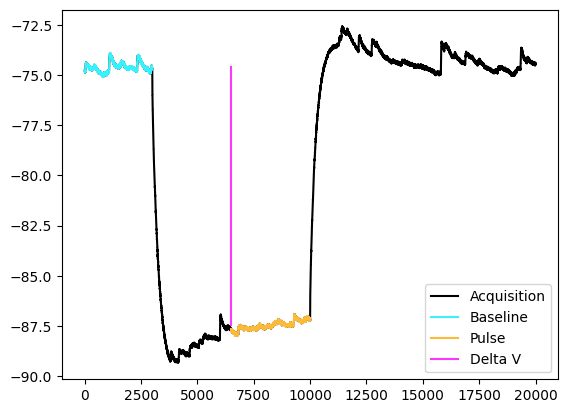

In [5]:
acq = exp_dict[153]["array"]

# We define the baseline as the mean of the acquisiton from 0 to 300 ms
baseline_v = np.mean(acq[baseline_start:baseline_end])

# We define the pulse voltage as the mean of the acquisition for the last 50% of the current injection
p50 = ((pulse_end - pulse_start) // 2) + pulse_start
injection_v = np.mean(acq[p50:pulse_end])
delta_v = injection_v - baseline_v
fig, ax = plt.subplots()
ax.plot(acq, c="black", label="Acquisition")
ax.plot(acq[baseline_start:baseline_end], c="#37f2fc", label="Baseline")
ax.plot(np.arange(p50, pulse_end), acq[p50:pulse_end], c="#fcba37", label="Pulse")
ax.plot([p50, p50], [baseline_v, injection_v], c="#fc37fc", label="Delta V")
_ = ax.legend()

Next we will need to measure the delta V for all pulses except those with spikes. The reason that we do not measure the delta V for acquisitions with spikes is that spiking activity is a seperate state compared to non-spiking. So we will simply exclude acquisitions with spikes. We will do this by ignoring acquisitions with voltages greater than -20 mV. We will also need the pulse amplitude of each acquisition which is located in the file.

Text(0, 0.5, 'Delta V (mV)')

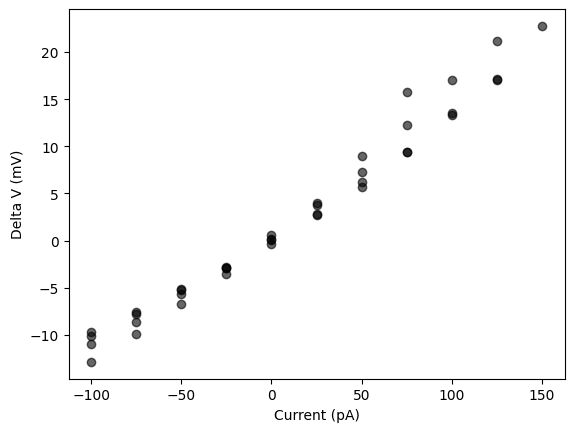

In [6]:
p50 = ((pulse_end - pulse_start) // 2) + pulse_start
delta_v = []
current_amplitude = []
for acq_num, acq in exp_dict.items():
    voltages = acq["array"]
    if np.max(voltages) < -20:
        current_amplitude.append(acq["pulse_amp"])
        baseline_v = np.mean(voltages[baseline_start:baseline_end])
        injection_v = np.mean(voltages[p50:pulse_end])
        delta_v.append(injection_v - baseline_v)
plt.plot(current_amplitude, delta_v, "o", c="black", alpha=0.6)
plt.xlabel("Current (pA)")
plt.ylabel("Delta V (mV)")

In the plot above you will notice there is a linear relationship between current and voltage. To get the membrane resistance from these data we just have to run a linear regression between the current and delta V. There are a couple ways that you can run the linear regression. One is you can take all delta Vs, you can take just a subset or you can rectify or take the absolute value of the delta Vs before running the regression. We will do all three since it is easy to do in Python. One really important thing to note is the units of the regressors. current is in pA and delta V is in mV and we need to get to MOhms. To do this we multiply the slope by 1000 to get MOhm. If you run the code below you see that the answers are fairly close. One reason to choose the subset version is that you may change the membrane resistance as the cell gets close to spiking even if it does not spike. However, all three calculations are valid.

All values: 133.09736486992492
Subset: 119.0104625490823
Rectified: 139.79142592501782


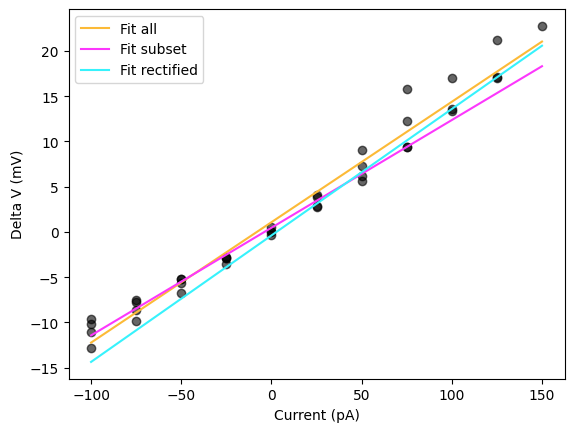

In [7]:
mem_res_all = stats.linregress(current_amplitude, delta_v)
subset = np.where(np.array(current_amplitude) <= 50)[0]
mem_res_subset = stats.linregress(
    np.array(current_amplitude)[subset], np.array(delta_v)[subset]
)
mem_res_rectified = stats.linregress(np.abs(current_amplitude), np.abs(delta_v))

# \n is just added to print on separate lines
print(
    f"All values: {mem_res_all.slope * 1000}",
    f"Subset: {mem_res_subset.slope * 1000}",
    f"Rectified: {mem_res_rectified.slope * 1000}",
    sep="\n",
)
x_fit = np.linspace(min(current_amplitude), max(current_amplitude), num=50)
plt.plot(current_amplitude, delta_v, "o", c="black", alpha=0.6)
plt.plot(
    x_fit,
    mem_res_all.intercept + x_fit * mem_res_all.slope,
    label="Fit all",
    c="#fcba37",
)
plt.plot(
    x_fit,
    mem_res_subset.intercept + x_fit * mem_res_subset.slope,
    label="Fit subset",
    c="#fc37fc",
)
plt.plot(
    x_fit,
    mem_res_rectified.intercept + x_fit * mem_res_rectified.slope,
    label="Fit rectified",
    c="#37f2fc",
)
plt.xlabel("Current (pA)")
plt.xlabel("Current (pA)")
plt.ylabel("Delta V (mV)")
plt.legend()

## Ih voltage sag
Hyperpolarization-activated cyclic nucleotide–gated (HCN) channels are typically responsible for the voltage sag in a current clamp acquisitions. Voltage sag is when the voltage drop is initially larger at the beginning of the current injection than at the end. Many cell types have Ih voltage sag such as dopaminergic cells and layer 5 pyramidal neurons. Measuring voltage sag is fairly straightforward. You just measure the voltage difference between the peak sag and and the voltage in the second half of the current injection similar to measuring delta V. The main way I have seen voltage sag reported is by measuring the sag on the most negative current injection. You could also technically run an IV curve for the voltage sag. To truly determine whether the voltage sag is due to HCN channels you would need to do a flow-in experiment with the drug ZD7288. If you want to run the IV curve I challenge you to modify the IV code above to get the resistance of the channels contributing to the voltage sag.

In [8]:
p50 = ((pulse_end - pulse_start) // 2) + pulse_start
delta_v = []
current_amplitude = []
sag_loc = []
acqs = []
for acq_num, acq in exp_dict.items():
    voltages = acq["array"]
    if acq["pulse_amp"] == -100:
        acqs.append(voltages)
        current_amplitude.append(acq["pulse_amp"])
        sag_v = np.min(voltages[pulse_start:p50])
        sag_loc.append(np.argmin(voltages[pulse_start:p50]) + pulse_start)
        injection_v = np.mean(voltages[p50:pulse_end])
        delta_v.append(sag_v - injection_v)
print(f"Voltage sag: {np.mean(delta_v):.3f} mV")

Voltage sag: -1.916 mV


Let's confirm that the voltage sag was correctly measured. Note that when we collected the sag location above we collected the sample number so that needs to be converted to time in ms by dividing by 10.

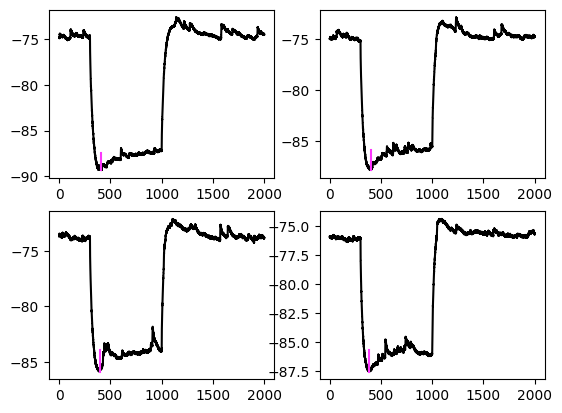

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax = ax.flatten()
for axes, sloc, dv, vs in zip(ax, sag_loc, delta_v, acqs):
    axes.plot(x_array, vs, c="black", label="Acquisition")
    axes.plot(
        [sloc / 10, sloc / 10], [vs[sloc], vs[sloc] - dv], c="#fc37fc", label="Delta V"
    )

## Rheobase
Rheobase is the minimum current required to get a cell to spike. This measure is directly related to membrane resistance through the equation: V=IR. When resistence increases, the current need to achieve the same delta V decreases. This means that a cell will higher membrane resistance will likely need less synaptic to be able to spike. There are a couple ways you can find rheobase. Find the minimum current needed to get the cell to spike out of all 4 cycles. I do not recommend this since there is variability between cycles and the variability could be affected by a treatment or other factors. Find the minimum current needed to get the cell to spike for each cycle and average the result. This is the method I recommend. The way I find rheobase below depends on the acquisitions being assigned to a cycle (1 to inf) which ClampSuite automatically. This may not be the case for your data. There are other ways to find rheobase


In [10]:
spiked = False
rheobase = []
rheobase_acq = []
for acq_num, acq in exp_dict.items():
    voltages = acq["array"]
    if np.max(voltages) > 0:
        if not spiked:
            rheobase.append(acq["pulse_amp"])
            rheobase_acq.append(acq_num)
        spiked = True
    else:
        spiked = False
print(f"Rheobase: {np.mean(rheobase)} pA")

Rheobase: 143.75 pA


Let's confirm that we have the right rheobase values by plotting the rheobase acquistion in red and the previous acquisition in black.

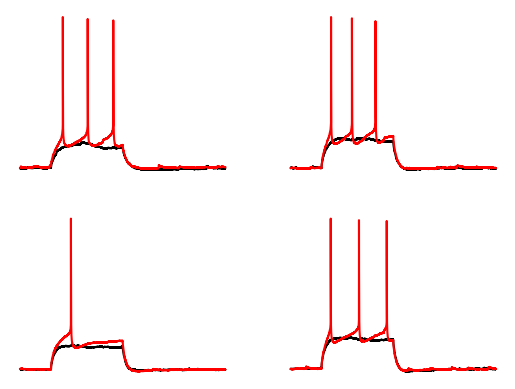

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax = ax.flatten()
for axes, acq in zip(ax, rheobase_acq):
    axes.plot(
        x_array,
        exp_dict[acq - 1]["array"],
        c="black",
    )
    axes.plot(
        x_array,
        exp_dict[acq]["array"],
        c="red",
    )
    axes.axis("off")

## Spike frequency
Spike frequency is used to create the FI curve. The FI curve relates several pieces of information such as rheobase, gain and maximum firing rate. The firing rate is calculated as the number of spikes that occur during the current injection or you can derive the firing rate from the inter-event (spike) interval (IEI or ISI). The IEI/ISI requires that you have at least two spikes in the acquisition. IEI/ISI is also useful because you can derive the firing rate variability within an acquisition. Three important features you can get from the FI curve that you will need to curve fit to get.
- Slope/gain: The input gain of a cell
- Maximum firing rate: The response gain of a cell
- Current offset
- The voltage offset: This is usually close to zero

If you want to learn more about gain I would recommend looking at Ferguson and Cardin, 2020 {cite}`ferguson_mechanisms_2020`. The Sigmoid curve and gain are explained in-depth below. If you are using the Jupyter Notebook version of the tutorial there is an interactive widget that allows you change the input and output gain of a the Sigmoic curve which can help understand how the different parameters change the curve.


### Sigmoid fit the FI curve to get the gain and max firing rate
Many papers will just analyze their FI data using a repeated measures ANOVA. However, this method only tells whether or not the FI curves are different and where they are different. To get a better idea of why the curves are different you really need to fit a sigmoid function data for each cell. This will get you the gain of a cell or the slope of the FI curve as well as the estimated maximum firing rate and the current offset. This is a simple example of how to do this in Python.

### Understanding of gain
Below is an example of how changes in gain would work. Note that to get a input gain difference without a rheobase difference the midpoint current has to be changed. That means to test whether there is a gain difference you will like nead to run a multivariate regression or ANOVA because these two factors are not independent.

Text(0.5, 1.0, 'Rheobase difference')

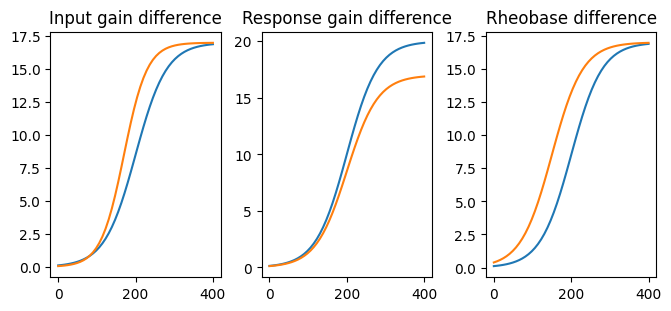

In [12]:
def sigmoid(x, max_value, midpoint, slope, offset):
    return 1 / (1 + np.exp((x - midpoint) / slope)) * max_value + offset


fig, ax = plt.subplots(ncols=3, layout="constrained", figsize=(6.6, 3))
x = np.linspace(0, 400)
ax[0].plot(x, sigmoid(x, 17, 200, -40, 0))
ax[0].plot(x, sigmoid(x, 17, 170, -30, 0))
ax[0].set_title("Input gain difference")
ax[1].plot(x, sigmoid(x, 20, 200, -40, 0))
ax[1].plot(x, sigmoid(x, 17, 200, -40, 0))
ax[1].set_title("Response gain difference")
ax[2].plot(x, sigmoid(x, 17, 200, -40, 0))
ax[2].plot(x, sigmoid(x, 17, 150, -40, 0))
ax[2].set_title("Rheobase difference")

Below is a simple interactive plot where you can play arount with the slope, max value and the midpoint of two sigmoid curves to get an idea of how each of the factors.

In [38]:
def explore_plots(
    response_gain_1,
    response_gain_2,
    input_gain_1,
    input_gain_2,
    current_offset_1,
    current_offset_2,
):
    fig, ax = plt.subplots(ncols=2, layout="constrained", figsize=(6.6, 3))
    y1 = sigmoid(x, response_gain_1, current_offset_1, input_gain_1, 0)
    y2 = sigmoid(x, response_gain_2, current_offset_2, input_gain_2, 0)
    _ = ax[0].plot(x, y1)
    _ = ax[0].plot(x, y2)
    _ = ax[1].plot(x, np.gradient(y1))
    _ = ax[1].plot(x, np.gradient(y2))


max_val_1 = FloatSlider(value=16.0, min=10.0, max=30.0, step=1.0)
max_val_2 = FloatSlider(value=16.0, min=10.0, max=30.0, step=1.0)
slope_1 = FloatSlider(value=-40, max=-5.0, min=-60.0, step=1.0)
slope_2 = FloatSlider(value=-40, max=-5.0, min=-60.0, step=1.0)
midpoint_1 = FloatSlider(value=200.0, min=25.0, max=400.0, step=1.0)
midpoint_2 = FloatSlider(value=200.0, min=25.0, max=400.0, step=1.0)
ws = {
    "input_gain_1": slope_1,
    "response_gain_1": max_val_1,
    "current_offset_1": midpoint_1,
    "input_gain_2": slope_2,
    "response_gain_2": max_val_2,
    "current_offset_2": midpoint_2,
}
ws_list = [HBox([Label(key), value]) for key, value in ws.items()]
left_box = VBox(ws_list[:3])
right_box = VBox(ws_list[3:])
ui = HBox([left_box, right_box])

out = widgets.interactive_output(explore_plots, ws)
display(ui, out)


Output()

### Fit the data to a sigmoid curve
First let's look at the FI data that we extract from the acquisitions

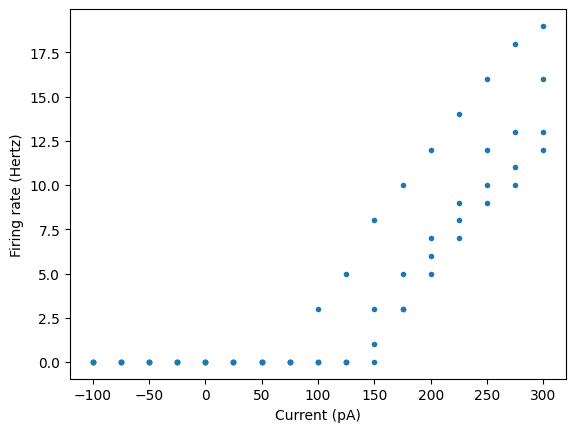

In [22]:
spike_analysis = {"acqs": [], "hertz": [], "current": []}
time = (pulse_end - pulse_start) / 10000

fig, ax = plt.subplots()
for acq_num, acq in exp_dict.items():
    voltages = acq["array"]
    peaks, _ = signal.find_peaks(
        voltages[pulse_start:pulse_end],
        height=-10,
        prominence=10,
    )
    spike_analysis["acqs"].append(acq_num)
    spike_analysis["hertz"].append(len(peaks))
    spike_analysis["current"].append(acq["pulse_amp"])
ax.plot(spike_analysis["current"], spike_analysis["hertz"], ".")
ax.set_ylabel("Firing rate (Hertz)")
_ = ax.set_xlabel("Current (pA)")

Slope (gain): -39.82500024303686
Max value: 16.094216952572022
Midpoint: 206.49508749307586
Max gain: 0.04045223095916439


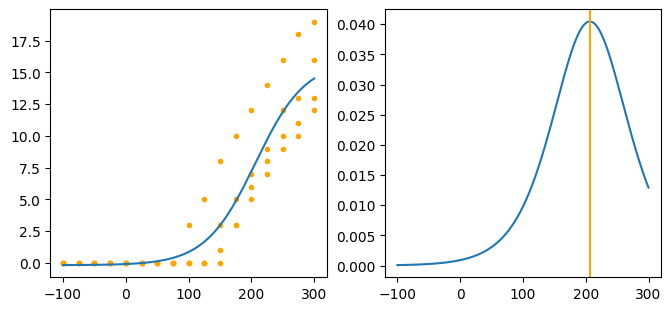

In [15]:
p, _ = optimize.curve_fit(sigmoid, spike_analysis["current"], spike_analysis["hertz"])
fit_x = np.linspace(
    min(spike_analysis["current"]), max(spike_analysis["current"]), 1000
)
fit_y = sigmoid(fit_x, p[0], p[1], p[2], p[3])
fig, ax = plt.subplots(ncols=2, layout="constrained", figsize=(6.6, 3))
ax[0].plot(spike_analysis["current"], spike_analysis["hertz"], ".", c="orange")
ax[0].plot(fit_x, fit_y)
diff = np.gradient(fit_y)
max_gain_index = diff.argmax()
max_gain = diff[max_gain_index]
max_current = fit_x[max_gain_index]
ax[1].plot(fit_x, diff)
ax[1].axvline(max_current, c="orange")
print(
    f"Slope (gain): {p[2]}",
    f"Max value: {p[0]}",
    f"Midpoint: {p[1]}",
    f"Max gain: {max_gain}",
    sep="\n",
)

## Spike threshold
Spike threshold is tells you at what voltage a cells spike is elicited. This different from rheobase. Spike threhold is primarly set by the number of sodium channels on the axon hillock. You can measure spike threshold on any acquisition that has a spike, however usually just the spikes from the rheobase acquisitions are used to calculate the spike threshold. There are several ways to calculate the spike threshold such a the first derivative, second derivative, third derivative, and a max curvature {cite}`sekerli_estimating_2004`. I find the third derivative to be the most consistent and it is the method that is used in this tutorial. We also will upsample the spike acquisition because every time we differentiate the signal we essentially smooth the signal and can loose important features. The way I typically differentiate signals is by using a special algorithm call gradient from the Numpy library. Unlike diff, gradient returns an array of the same length as the input signal which makes downstream analysis easier. It has the downside in that if you have small peaks you will get some artifacts in the signal which upsampling can conteract. One problem I found with the third derivative is that the peaks found a usually to late by 1 sample at 10000 Hz so I adjust the spike threshold backwards by 1 sample (or 4 in since we are going to upsample by a factor of 4). I also z-score the derivative since this keeps the peak finding threshold consistent between acquisitions.

First lets look a single acquisition to see how the method works. One thing we are going to do just for visualization purposes is limit the extent of the x-axis so that we are just looking at the first spike. If you look at the third derivative we want to extract the first positive peak. There are some additions that I have found are helpful.

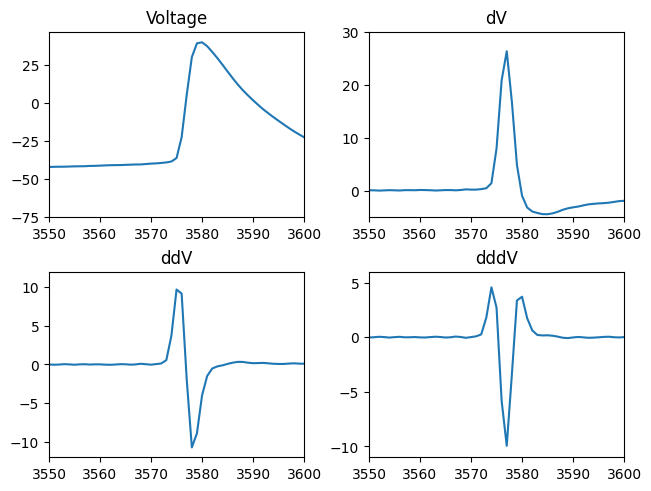

In [16]:
voltages = np.array(exp_dict[rheobase_acq[0]]["array"])

# grab the voltages just inside the current pulse
voltages = voltages[pulse_start:pulse_end]
dv = np.gradient(voltages)
ddv = np.gradient(dv)
dddv = np.gradient(ddv)
fig, ax = plt.subplots(nrows=2, ncols=2, layout="constrained")
ax = ax.flatten()
ax[0].plot(voltages)
ax[0].set_title("Voltage")
ax[1].plot(dv)
ax[1].set_title("dV")
ax[1].set_ylim(-5, 30)
ax[2].plot(ddv)
ax[2].set_title("ddV")
ax[2].set_ylim(-12, 12)
ax[3].plot(dddv)
ax[3].set_title("dddV")
ax[3].set_ylim(-11, 6)
for a in ax:
    a.set_xlim(3550, 3600)

In [17]:
spike_threshold_x = []
spike_threshold_y = []

for acq_num in rheobase_acq:
    voltages = np.array(exp_dict[acq_num]["array"])
    peaks, _ = signal.find_peaks(
        voltages[pulse_start:pulse_end],
        height=-10,
        prominence=10,
    )
    peaks += pulse_start

    dv = np.gradient(voltages)
    ddv = np.gradient(dv)
    dddv = np.gradient(ddv)


    temp = dddv[pulse_start : peaks[0]]
    base = temp.argmin()
    index = base - 1
    val = temp[base] - temp[index]
    while val < 0:
        index -= 1
        base -= 1
        val = temp[base] - temp[index]
    thresh_peak = pulse_start + index
    spike_threshold_x.append(thresh_peak)
    spike_threshold_y.append(voltages[thresh_peak])
print(f"Spike threshold: {np.mean(spike_threshold_y):.3f} mV")

Spike threshold: -40.635 mV


Let's inspect the output. While it may look like the spike threshold is climbing up the spike a little bit, it is important to remember what a failed spike looks like. There is often a hump suggesting there is a small and rapid climb in voltage before a spike can occur even if the spike does not occur. We are trying to find that bifurcation point. Unfortunately, I did not include an acquisition with a failed spike to show the difference.

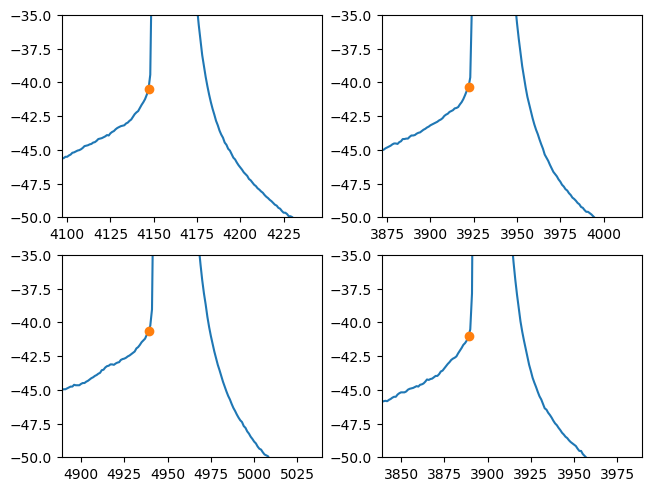

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, layout="constrained")
ax = ax.flatten()
for a, sx, sy, acq_num in zip(ax, spike_threshold_x, spike_threshold_y, rheobase_acq):
    voltages = np.array(exp_dict[acq_num]["array"])
    a.plot(voltages)
    a.plot(sx, sy, "o", color="#ff7f0e")
    a.set_xlim(sx - 50, sx + 100)
    a.set_ylim(-50, -35)

## Spike (half) width
The next waveform feature that we can measure is the spike (half) width. This is where the voltage crosses half way between the spike threshold and spike peak. Note that the spike threshold collected previously will be used to help find the spike width.

In [19]:
spike_width_x = []
spike_width_y = []
for acq_num, sy in zip(rheobase_acq, spike_threshold_y):
    voltages = np.array(exp_dict[acq_num]["array"])
    v_upsampled = signal.resample_poly(voltages, 80, 20)
    masked_array = v_upsampled.copy()
    mask = np.array(v_upsampled > sy)
    masked_array[~mask] = sy
    peaks, _ = signal.find_peaks(
        masked_array[pulse_start * 4 : pulse_end * 4],
        height=-10,
        prominence=10,
    )
    peaks += pulse_start * 4
    width = signal.peak_widths(masked_array[: pulse_end * 4], peaks, rel_height=0.5)
    spike_width_x.append([width[2][0] / 4, width[3][0] / 4])
    spike_width_y.append(width[1][0])
print(f"Spike (half) width: {np.mean([(i[1]-i[0])/10 for i in spike_width_x]):.3f} ms")

Spike (half) width: 1.105 ms


Let's inspect the spike width measurements to make sure they are correct.

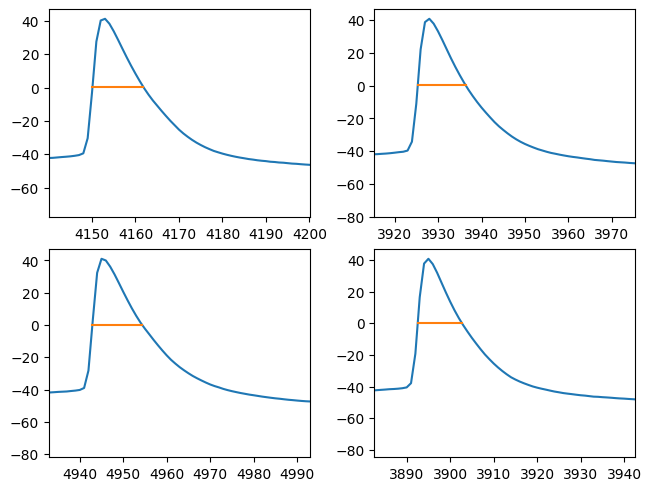

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, layout="constrained")
ax = ax.flatten()
for a, sx, sy, acq_num in zip(ax, spike_width_x, spike_width_y, rheobase_acq):
    voltages = np.array(exp_dict[acq_num]["array"])
    a.plot(voltages)
    a.plot(sx, [sy, sy], color="#ff7f0e")
    a.set_xlim(sx[0] - 10, sx[0] + 50)

```{bibliography}
:filter: docname in docnames
```